## Example using constrained GP model
This is the code used to produce the 'corroded pipeline' example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

### Imports

In [1]:
### Basic imports ###
import sys, os

# For plotting
import plotly
import plotly.plotly as pltly
import plotly.graph_objs as go
import plotly.offline as pltlyoff
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE
import pandas as pd

### Custom files ###

# Path to custom plotly module 'GPPlotly' for plotting 
# can be downloaded at https://github.com/cagrell/gp_plotly
dir_GPPlotly = 'C:\\Data\\git repos\\gp_plotly\\'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = 'C:\\Data\\git repos\\gp_constr\\'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig, gp_diagnostics, pred_vs_error_perc
from GPConstr.model import kernel_RBF, GPmodel, Constraint

### Setup notebook ###
pltlyoff.init_notebook_mode(connected=True)
print('Python version', sys.version)

Loading constrained GP module from C:\Data\git repos\gp_constr
Loading R wrapper...
Running R from rpy2: R version 3.4.3 (2017-11-30)


Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]


## 1. Define function for generating synthetic test/training data
The simplified pipe burst capacity in RP-F101

$P_{cap}(\sigma_{u}, D, t, d, l) = 1.05\frac{2t \sigma_{u}}{D - t} \frac{1 - d/t}{1 - \frac{d/t}{Q}}$, $Q = \sqrt{1 + 0.31\frac{l^{2}}{Dt}}$

We have the following constraints

1.) $0 \leq P_{cap} \leq 1.05\frac{t \sigma_{u}}{D - t}$

2.) $\frac{\partial P_{cap}}{\partial \sigma_{u}} > 0$

3.) $\frac{\partial P_{cap}}{\partial D} < 0$

4.) $\frac{\partial P_{cap}}{\partial t} > 0$

5.) $\frac{\partial P_{cap}}{\partial d} < 0$

6.) $\frac{\partial P_{cap}}{\partial l} < 0$

for $\sigma_{u} \in [450, 550]$ (MPa), $t \in [5, 30]$ (mm), $D \in [10t, 50t]$ (mm), $d \in [0, t]$ (mm) and $l \in [0, 1000]$ (mm).

Let $\textbf{x}$ denote the transformed input vector $\textbf{x} = [x_{1}, \dots, x_{5}]$ where $x_{1} = (\sigma_{u} - 450)/(550-450)$, $x_{2} = (D/t - 10)/(50 - 10)$, $x_{3} = (t - 5)/(30-5)$, $x_{4} = d/t$ and $x_{5} = l/1000$.  

We will make use of the function

$f(\textbf{x}) = P_{cap}(\textbf{x})$ with the corresponding constraints

1.) $0 \leq f(\textbf{x}) \leq 1.05\frac{2t \sigma_{u}}{D - t}$ 
$= 1.05 \cdot 2\frac{x_{1}(550-450)+450}{x_{2}(50-10)+10}$
$= 10.5\frac{x_{1} + 9}{4x_{2} + 1}$

2.) $\frac{\partial f}{\partial x_{1}} > 0$

3.) $\frac{\partial f}{\partial x_{2}} < 0$

4.) $\frac{\partial f}{\partial x_{3}} > 0$

5.) $\frac{\partial f}{\partial x_{4}} < 0$

6.) $\frac{\partial f}{\partial x_{5}} < 0$

for $\textbf{x} \in [0, 1]^{5}$.


In [2]:
# Function to emulate/estimate
def burst_cap(su, D, t, d, l):
    """ 
    Simplified burst capacity equation in DNV GL RP-F101 
    
    Input:    
    su =  Ultimate tensile strength [MPa]
    D  =  Pipe diameter             [mm]
    t  =  Pipe wall thickness       [mm]
    d  =  Defect depth              [mm]
    l  =  Defect length             [mm]

    """
    
    p0 = 1.05*2*t*su/(D-t)               # Un-corroded capacity
    Q = np.sqrt(1 + 0.31*(l**2)/(D*t))   # Length factor
    d_t = d/t                            # Relative depth
    R = (1-d_t)/(1 - d_t/Q)              # Capacity reduction factor due to the defect
    
    p_cap = p0*R                         # Capacity of pipe with defect
    
    return p_cap

# Ranges of input variables
rng = {
    'su':(450, 550),
    't': (5, 30),
    'D_t': (10, 50),
    'd_t': (0, 1),
    'l': (0, 1000),
}

def phys_to_x(su, D, t, d, l):
    """ Transform from physical to standardized domain """
    
    x = np.array([
        (su - rng['su'][0])/(rng['su'][1] - rng['su'][0]),
        (D/t - rng['D_t'][0])/(rng['D_t'][1] - rng['D_t'][0]),
        (t - rng['t'][0])/(rng['t'][1] - rng['t'][0]),
        (d/t - rng['d_t'][0])/(rng['d_t'][1] - rng['d_t'][0]),
        (l - rng['l'][0])/(rng['l'][1] - rng['l'][0])
    ])
    
    return x

def x_to_phys(x):
    """ Transform from standardized to physical domain """
    su = x[0]*(rng['su'][1] - rng['su'][0]) + rng['su'][0]
    D_t = x[1]*(rng['D_t'][1] - rng['D_t'][0]) + rng['D_t'][0]
    t = x[2]*(rng['t'][1] - rng['t'][0]) + rng['t'][0]
    d_t = x[3]*(rng['d_t'][1] - rng['d_t'][0]) + rng['d_t'][0]
    l = x[4]*(rng['l'][1] - rng['l'][0]) + rng['l'][0]
    
    return su, D_t*t, t, d_t*t, l

def fun(x):
    """ function used to generate data """
    p_cap = burst_cap(*x_to_phys(x))
    return p_cap

def fun_mult(X):
    """ For multiple x in array X """
    return np.array([fun(X[i,:]) for i in range(X.shape[0])])

In [3]:
# Generate some samples to plot

data = []

for _ in range(1000):
    x = np.random.uniform(size = 5)
    y = fun(x)
    
    data.append(list(x_to_phys(x)) + [y])
    
df = pd.DataFrame(data)
df.columns = ['su', 'D', 't', 'd', 'l', 'y_true']
#df['y_mean'] = df['y_true'] 
#df['y_var'] = np.ones(df.shape[0])*0.001
df['D_t'] = df['D'] / df['t'] 

df.head()

,su,D,t,d,l,y_true,D_t
0,509.307542,991.888533,28.241311,15.873133,545.238884,18.839808,35.121901
1,516.485501,1016.121583,21.048944,19.584743,623.904596,2.497713,48.274231
2,517.478627,337.884135,8.970343,3.948478,52.938940,27.113257,37.666801
3,519.221213,401.057510,15.477981,11.740013,760.573331,12.273243,25.911487
4,464.725289,565.098506,12.352602,6.651423,772.181401,11.218271,45.747327


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A43252B940>]],
      dtype=object)

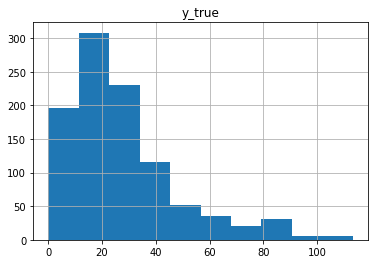

In [4]:
# Histogram of output
%matplotlib inline
df.hist(column = 'y_true')

In [ ]:
import seaborn as sns

sns.pairplot(df[df['y_true'] < 400])

## 2. Emulation (no noise) in $\mathbb{R}^{4}$

### 2.1. Generate synthetic training data

In [13]:
# Design data 
n_samples = 40
input_dim = 5

x_design = pyDOE.lhs(input_dim, samples = n_samples, criterion = 'maximin', iterations = 1000)
#y_design = fun_mult(x_design) # No Noise

noise_std = 2
y_design = fun_mult(x_design) + np.random.normal(0, noise_std, n_samples) # With noise


### 2.2. Define GP model (without constraints)

In [14]:
# Set up model
ker = kernel_RBF(variance = 1, lengthscale = [1]*input_dim)
#model = GPmodel(kernel = ker, likelihood = 1E-6, mean = 0) # No Noise
model = GPmodel(kernel = ker, likelihood = 1, mean = 0) # With noise

# Training data
model.X_training = x_design
model.Y_training = y_design

In [51]:
# Optimize
model.kernel.variance = 1
model.likelihood = 1
model.kernel.lengthscale = [1]*input_dim
model.optimize(include_constraint = False, fix_likelihood = False)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.372 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 15.953989825541113 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [166.62353981   0.78958619  12.79045948   1.314086     8.86446863] 
   variance = 7858.383498665717 
 constraint: 
   df/dx_1 [4], df/dx_2 [9], df/dx_3 [2], df/dx_4 [2], df/dx_5 [0] 
   constr_likelihood = 1e-06 
---------------------


#### Test the unconstrained model 

In [16]:
# Helper function - put test data in dataframe
def get_diagnostics_df(x_test, y_test, mean, var):
    df = pd.DataFrame(x_test)
    df.columns = ['x' + str(i+1) for i in range(x_test.shape[1])]
    df['y_true'] = y_test
    df['y_mean'] = mean
    df['y_var'] = var
    
    return df

In [17]:
# Test data
n_test = 100
x_test = np.random.rand(n_test, input_dim) # Uniform samples
y_test = fun_mult(x_test)

# Run unconstrained model
mean_unconstr, var_unconstr = model.calc_posterior_unconstrained(x_test, full_cov = False)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.array(var_unconstr).flatten()

# Collect data in df
df_unconstr = get_diagnostics_df(x_test, y_test, mean_unconstr, var_unconstr)


..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.000 seconds


In [18]:
# View first couple of records of dataframe with testing data
df_unconstr.head()

,x1,x2,x3,x4,x5,y_true,y_mean,y_var
0,0.843630,0.712505,0.616663,0.957360,0.715482,1.797463,3.775408,11.161993
1,0.279115,0.488765,0.659174,0.574648,0.624797,18.297855,19.693961,2.277359
2,0.701320,0.973875,0.102103,0.275887,0.327439,17.865397,22.955061,11.948403
3,0.963529,0.121429,0.208930,0.030285,0.987700,80.464444,71.039322,14.029764
4,0.677465,0.044768,0.128814,0.718610,0.142073,37.380512,35.329157,6.570889


In [19]:
# Plot diagnostics
#figs = gp_diagnostics(df_unconstr, y_name = 'y', subplots = True)
#for fig in figs:
#    pltlyoff.iplot(fig, filename='')

figs = gp_diagnostics(df_unconstr, y_name = 'y', subplots = False)
pltlyoff.iplot(figs[1], filename='')

#### Plot a 1D slice of the model

In [21]:
plot_x_dim = 2 # Dimension to plot
x_base_val = 0.5 # All other x has this value

# Test input
px_test = np.linspace(0, 1, 100)
px_test_arr = np.ones((len(px_test), input_dim))*x_base_val
px_test_arr[:,plot_x_dim] = px_test

# True function
y_true = fun_mult(px_test_arr)

# From GP
mean_unconstr, cov_unconstr = model.calc_posterior_unconstrained(px_test_arr, full_cov = True)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.diagonal(cov_unconstr)

num_samples = 10
show_samplepaths = True
samplepaths_unconstr = []
if show_samplepaths: samplepaths_unconstr = np.random.multivariate_normal(mean_unconstr, cov_unconstr, num_samples).T

fig_unconstr_slice = PlotGP2d(x_mean = px_test, mean = mean_unconstr, var = var_unconstr,
                        x_true = px_test, y_true = y_true,
                        samplepaths = samplepaths_unconstr,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val), xrange = [0, 1], smoothing = False)

pltlyoff.iplot(fig_unconstr_slice, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.008 seconds


### 2.2.3. Include the constraints

In [22]:
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return np.array([val]*x.shape[0])
    
    return fun

In [23]:
# Create derivative constraints
constr_deriv = [
    Constraint(LB = constant_function(0), UB = constant_function(float('Inf'))),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0)),
    Constraint(LB = constant_function(0), UB = constant_function(float('Inf'))),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0)),
    Constraint(LB = constant_function(float('-Inf')), UB = constant_function(0))
]

In [24]:
# Add constraints to model
model.constr_deriv = constr_deriv
model.constr_likelihood = 1E-6

In [25]:
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 15.953989825541113 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [166.62353981   0.78958619  12.79045948   1.314086     8.86446863] 
   variance = 7858.383498665717 
 constraint: 
   df/dx_1 [0], df/dx_2 [0], df/dx_3 [0], df/dx_4 [0], df/dx_5 [0] 
   constr_likelihood = 1e-06 
---------------------


In [55]:
# Search for a suitable set of virtual observation locations where the constraint is imposed
df = model.find_XV_subop(bounds =  [(0.001, 1)]*input_dim, p_target = 0.9, 
                         max_iterations = 2,
                         min_prob_unconstr_xv = -1, opt_method = 'differential_evolution')

Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [df/dx_1, df/dx_2, df/dx_3, df/dx_4, df/dx_5] and nu = 1.2815515655446004e-06 ...
i = 4, XV[1] = [1.         0.92668595 1.         0.31731581 0.001     ], prob = 0.511779172240259, acc. rate = 0.0016716773612896363, optimization time = 26.315 seconds
i = 2, XV[2] = [0.001      0.85685455 0.001      0.37670559 1.        ], prob = 0.8355522579742862, acc. rate = 0.0016716773612896363, optimization time = 25.047 seconds
DONE - Found 2 points. Min. constraint prob = 0.8355522579742862. Total time spent = 53.531 seconds


In [32]:
# Search for a suitable set of virtual observation locations where the constraint is imposed
df = model.find_XV_subop(bounds =  [(0, 1)]*input_dim, p_target = 0.9, 
                         max_iterations = 10, moment_approximation = False, num_samples = 100,
                         min_prob_unconstr_xv = -1, opt_method = 'shgo', print_intermediate = False)

Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [df/dx_1, df/dx_2, df/dx_3, df/dx_4, df/dx_5] and nu = 1.2815515655446004e-06 ...
DONE - Found 2 points. Min. constraint prob = 0.9239438963977165. Total time spent = 4.449 seconds


In [35]:
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 15.953989825541113 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [166.62353981   0.78958619  12.79045948   1.314086     8.86446863] 
   variance = 7858.383498665717 
 constraint: 
   df/dx_1 [4], df/dx_2 [9], df/dx_3 [2], df/dx_4 [2], df/dx_5 [0] 
   constr_likelihood = 1e-06 
---------------------


In [ ]:
# Define seed-set of virtual observation locations 
# (same set for all constraints in this case)
#x_seed = pyDOE.lhs(input_dim, samples = 40, criterion = 'maximin', iterations = 1000)
for constr in model.constr_deriv:
    #constr.Xv = x_seed
    constr.Xv = pyDOE.lhs(input_dim, samples = 80, criterion = 'maximin', iterations = 1000)

print(model)
print('constr prob', model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 1000))

In [ ]:
print(model)
model.reset()
print('constr prob', model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 1000))

In [36]:
def print_constr_loglik(model, intermediate = True):
    v_loglik_unconstr = model._loglik_unconstrained() # P(Y)
    v_loglik_constr = np.log(model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 1000)) # P(C|Y)
    
    if intermediate:
        print('P(Y)', v_loglik_unconstr)
        print('P(C|Y) {} ({})'.format(v_loglik_constr, np.exp(v_loglik_constr)))
    
    print('P(Y, C)', v_loglik_unconstr + v_loglik_constr)

In [52]:
model.reset()
print_constr_loglik(model)

P(Y) -135.72727180349636
P(C|Y) -10.180760203870443 (3.7892392035711934e-05)
P(Y, C) -145.9080320073668


In [54]:
model._EM_update(fix_likelihood = True, bounds = None, n = 100, verbatim = True)
print(model)
print_constr_loglik(model)

..Running calculation of g(theta~) ... DONE - time: 0.012 seconds
..Running optimization (L-BFGS-B) ... DONE - time: 1.848 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 15.953989825541113 
 kernel: 
   type = RBF 
   input dim = 5 
   lenghtscale = [144.46725388   0.85388097  17.90719016   0.84390364   9.82015295] 
   variance = 7857.630677656045 
 constraint: 
   df/dx_1 [4], df/dx_2 [9], df/dx_3 [2], df/dx_4 [2], df/dx_5 [0] 
   constr_likelihood = 1e-06 
---------------------
P(Y) -136.13878166013322
P(C|Y) -6.391638317978934 (0.0016755089351435865)
P(Y, C) -142.53041997811215


In [ ]:
# Optimize constrained

bounds = [(1e-1, None)]*6

model._optimize_constrained(fix_likelihood = True, conditional = False, opt_method = 'L-BFGS-B', 
                            algorithm = 'minimax_tilting', n = 100, bounds = bounds)
print(model)

In [ ]:
# Optimize
model.optimize(include_constraint = False, fix_likelihood = True)
print(model)

In [ ]:
#ker = kernel_RBF(variance = 1, lengthscale = [1]*input_dim)

model.kernel.variance = 1
model.kernel.lengthscale = [1]*input_dim

print(model)

In [ ]:
t0 = time.time()
p = model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 1000)
print('p', p)
print('time', time.time() - t0)

In [ ]:
t0 = time.time()
p = model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 1000)
print('p', p)
print('time', time.time() - t0)

## Plot likelihood

In [ ]:
def loglik_unconstr(x):
    i = 1
    
    tmp = model.kernel.lengthscale[i]
    model.kernel.lengthscale[i] = x
    
    model.reset()
    res = model._loglik_unconstrained()
    
    model.kernel.lengthscale[i] = tmp
    model.reset()
    
    return res

def loglik_constr(x):
    i = 1
    
    tmp = model.kernel.lengthscale[i]
    model.kernel.lengthscale[i] = x
    
    model.reset()
    
    v_loglik_unconstr = model._loglik_unconstrained() # P(Y)
    v_loglik_constr = np.log(model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 100)) # P(C|Y)
            
    res = v_loglik_unconstr + v_loglik_constr # P(Y, C)
    
    model.kernel.lengthscale[i] = tmp
    model.reset()
    
    return res

In [ ]:
# Optimize unconstrained
model.optimize(include_constraint = False, fix_likelihood = True)
print(model)

In [ ]:
# Compute likelihood
#x = np.linspace(5, 40, 20)
x = np.linspace(0.1, 0.35, 30)
v_loglik_unconstr = np.array([loglik_unconstr(xx) for xx in x])

In [ ]:
import time
t0 = time.time()
v_loglik_constr = np.array([loglik_constr(xx) for xx in x])
print(time.time() - t0)

In [ ]:
t0 = time.time()
p = model.constrprob_Xv(posterior = True, algorithm = 'minimax_tilting', n = 1000)
print('p', p)
print('time', time.time() - t0)

In [ ]:
# Plot likelihood
trace_P_Y = go.Scatter(x = x, y = v_loglik_unconstr, mode = 'lines', name = 'ln P(Y)')
trace_P_YC = go.Scatter(x = x, y = v_loglik_constr, mode = 'lines', name = 'ln P(Y, C)')

data = [trace_P_Y, trace_P_YC]
layout = go.Layout(title = 'log-likelihood', xaxis=dict(title = 'lengthscale'), yaxis=dict(title = 'log likelihood'))
fig = go.Figure(data = data, layout = layout)
pltlyoff.iplot(fig, filename='')

In [ ]:
pltlyoff.iplot(fig, filename='')

In [ ]:

# Set optimization bounds manually
bound_lik = None
bound_ker_var = (100, 5000)
bound_ker_len = [(0.1, 10)]*input_dim

bounds = [bound_lik] if bound_lik is not None else []
bounds = bounds + [bound_ker_var] + bound_ker_len



In [ ]:
# Optimize constrained
#model.constr_likelihood = 1E-1
#model.likelihood = 0.1
#model.kernel.lengthscale = [1, 1, 1, 1, 1]
#model.kernel.variance = 1

#model.reset()
#model.optimize(include_constraint = True, conditional = True, fix_likelihood = True, bound_min = 0.1, pc_alg = 'minimax_tilting', n = 10)


# Set optimization bounds manually
bound_lik = None
bound_ker_var = (900, 5000)
bound_ker_len = [(0.1, 10)]*input_dim

bounds = [bound_lik] if bound_lik is not None else []
bounds = bounds + [bound_ker_var] + bound_ker_len

# Optimize
model.reset()
model._optimize_constrained(fix_likelihood = True, opt_method = 'differential_evolution', algorithm = 'minimax_tilting',
                            n = 10, conditional = True, bounds = bounds)

print(model)

In [ ]:
print(model)

In [ ]:
print(model)

In [ ]:
model.constr_likelihood = 1E-1
model.likelihood = 0.1
model.kernel.lengthscale = [1, 1, 1, 1, 1]

print(model.kernel.likelihood)
print(model.kernel)

In [ ]:
# Optimize hyperparameters
#model.optimize(include_constraint = True, fix_likelihood = True, n = 10)
#opt_args = {'options' : {'maxtime ':10}}
opt_args = {}
model._optimize_constrained(fix_likelihood = True, opt_method = 'shgo', algorithm = 'minimax_tilting', n = 10, opt_args = opt_args)
print(model)

In [ ]:
model.kernel.variance = 10000
model.reset()
print(model)

In [ ]:
# Print constraint probability P(C)
model.constrprob_Xv(n = 10)

#### Test the constrained model 

In [56]:
percentiles = [0.025, 0.5, 0.975]
mean, var, perc, mode, samples = model.calc_posterior_constrained(x_test, compute_mode = False, num_samples = 1000, save_samples = 30, algorithm = 'minimax_tilting', resample = False)
mean = np.array(mean).flatten()
lower = perc[0]
upper = perc[2]
var = np.array(var).flatten()

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.008 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.004 seconds
..sampling 1000 times from truncated constraint distribution C~|C, Y DONE - time: 0.040 seconds
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.016 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 0.080 seconds


In [57]:
pltlyoff.iplot(figs[1], filename='')

In [58]:
fig = pred_vs_error_perc(mean, lower, upper, y_test, 95)
pltlyoff.iplot(fig, filename='')
print('With optimization P(Y, C)')
print('P(C)', model.constrprob_Xv(n = 100))

With optimization P(Y, C)
P(C) 0.0007205830604316459


In [ ]:
fig = pred_vs_error_perc(mean, lower, upper, y_test, 95)
pltlyoff.iplot(fig, filename='')
print('No optimization')
print('P(C)', model.constrprob_Xv(n = 100))

In [ ]:
# Show plot as static image
Image(pio.to_image(fig, width=700, height=500, scale=1, format='png'))

#### Plot a 1D slice of the constrained model

In [ ]:
# Plot constrained
mean, var, perc, mode, samples = model.calc_posterior_constrained(px_test_arr, compute_mode = False, num_samples = 1000, algorithm = 'minimax_tilting', resample = False)

p_lower = perc[0]
p_upper = perc[2]
p_label = '[p{}, p{}] conf.'.format(10, 90)

samplepaths_Z = []
if show_samplepaths: 
    samplepaths_Z = np.array(samples)

fig_constrained_1 = PlotGP2d(x_mean = px_test, mean = np.array(mean).flatten(),
                        samplepaths =  samplepaths_Z,
                        x_true = px_test, y_true = y_true,
                        p_lower = p_lower, p_upper = p_upper, p_label = p_label,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val))

pltlyoff.iplot(fig_constrained_1, filename='')

In [ ]:
# Show plot as static image
Image(pio.to_image(fig_constrained_1, width=700, height=500, scale=1, format='png'))